### 06. Count the pairs of victimisation experiences and observations.

---
In this section, we use the two tables from the previous sections to combine the two different mechanisms.

**Things to do**
* Test the results.
* Make code modular (create a function for plotting).

In [1]:
from pyspark.sql.functions import col, lit, when
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read a summary table of the victimisation-based mechanism.
PATH_TO_VIC_DATA = "s3://social-research-cheating/summary-tables/emp-net/vic_tab_30.parquet"
vic_data = spark.read.parquet(PATH_TO_VIC_DATA)
vic_data.registerTempTable("vic_data")

# Read a summary table of the observation-based mechanism.
PATH_TO_OBS_DATA = "s3://social-research-cheating/summary-tables/emp-net/sev_obs/emp_30.parquet"
obs_data = spark.read.parquet(PATH_TO_OBS_DATA)
obs_data.registerTempTable("obs_data")

In [3]:
# Collect the transitions that happened within seven days after observing or being killed by cheating.
vic_tab = spark.sql("SELECT * FROM vic_data WHERE period <= 7")
obs_tab = spark.sql("SELECT * FROM obs_data WHERE period <= 7")

vic_tab.registerTempTable("vic_tab")
obs_tab.registerTempTable("obs_tab")

In [4]:
# Show the first few rows of each dataset.
vic_tab.show(5)
obs_tab.show(5)

# Convert spark dataframes into pandas dataframes.
obs_df = obs_tab.toPandas()
vic_df = vic_tab.toPandas()

+--------------------+----------+----------+------+---------+-------------+------------+
|                  id|start_date|    m_date|period|total_exp|total_sev_exp|uniq_killers|
+--------------------+----------+----------+------+---------+-------------+------------+
|account.393b6ee09...|2019-03-08|2019-03-01|     7|        2|            1|           2|
|account.3f888b606...|2019-03-10|2019-03-05|     5|        7|            4|           7|
|account.4b6c650bd...|2019-03-15|2019-03-11|     4|        2|            0|           2|
|account.73e50018a...|2019-03-27|2019-03-20|     7|        1|            1|           1|
|account.b3e7bbe4a...|2019-03-09|2019-03-04|     5|        1|            0|           1|
+--------------------+----------+----------+------+---------+-------------+------------+
only showing top 5 rows

+--------------------+----------+----------+------+---------+-------------+--------------+------------+
|                  id|start_date|    m_date|period|total_obs|total_sev

### 1. Merge two tables.

In [5]:
# Create a table that contains player (cheater) IDs and the start dates of cheating adoption for each cheater
dates_obs = obs_df[['id', 'start_date']]
dates_vic = vic_df[['id', 'start_date']]
dates_df = pd.concat([dates_obs, dates_vic])
dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
dates_df = spark.createDataFrame(dates_df)
dates_df.registerTempTable("dates_df")
dates_df.show(10)

+--------------------+----------+
|                  id|start_date|
+--------------------+----------+
|account.14a9052f2...|2019-03-08|
|account.8d20619cf...|2019-03-06|
|account.89e89a88e...|2019-03-08|
|account.72d7c8781...|2019-03-06|
|account.2bc8b50ec...|2019-03-05|
|account.d5bdf5693...|2019-03-05|
|account.ed34dc343...|2019-03-10|
|account.826ffb6b1...|2019-03-10|
|account.d09650395...|2019-03-10|
|account.2ec53847e...|2019-03-11|
+--------------------+----------+
only showing top 10 rows



In [6]:
add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                            CASE WHEN total_cheaters IS NULL THEN 0 ELSE total_cheaters END AS total_obs, 
                            CASE WHEN sev_cheaters IS NULL THEN 0 ELSE sev_cheaters END AS sev_obs 
                            FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
add_obs_info.registerTempTable("add_obs_info")

merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                         CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                         CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                         FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
merged_df.show(10)

+--------------------+----------+---------+-------+---------+-------+
|                  id|start_date|total_obs|sev_obs|total_exp|sev_exp|
+--------------------+----------+---------+-------+---------+-------+
|account.14a9052f2...|2019-03-08|        8|      3|        6|      3|
|account.8d20619cf...|2019-03-06|        1|      1|        0|      0|
|account.89e89a88e...|2019-03-08|        5|      3|        3|      2|
|account.72d7c8781...|2019-03-06|        3|      1|        0|      0|
|account.2bc8b50ec...|2019-03-05|        0|      0|        0|      0|
|account.d5bdf5693...|2019-03-05|        0|      0|        0|      0|
|account.ed34dc343...|2019-03-10|        0|      0|        0|      0|
|account.826ffb6b1...|2019-03-10|        0|      0|        0|      0|
|account.d09650395...|2019-03-10|        1|      1|        1|      0|
|account.2ec53847e...|2019-03-11|        3|      1|        1|      0|
+--------------------+----------+---------+-------+---------+-------+
only showing top 10 

### 2. Plot the distribution of experiences and observations.

In [7]:
merged_tab = merged_df.toPandas()
pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")

# Print the first 5 and last 5 rows.
print(pairs_tab.head())
print(pairs_tab.tail())

   total_obs  total_exp  freq
0          0          0   644
1          0          1   180
2          0          2    29
3          0          3    11
4          0          4     1
    total_obs  total_exp  freq
71         19          7     1
72         25          2     1
73         26          2     1
74         27          4     1
75         37          2     1


In [8]:
# Store the dataframe as an excel file.
pairs_tab.to_csv('emp_tab_5_7.csv', index=False)

In [9]:
merged_tab = merged_df.toPandas()
sev_pairs_tab = merged_tab.groupby(['total_obs', 'sev_exp']).size().reset_index(name="freq")

# Print the first 5 and last 5 rows.
print(sev_pairs_tab.head())
print(sev_pairs_tab.tail())

# Store the dataframe as an excel file.
sev_pairs_tab.to_csv('sev_emp_tab_5_7.csv', index=False)

   total_obs  sev_exp  freq
0          0        0   805
1          0        1    58
2          0        2     4
3          0        3     1
4          1        0   385
    total_obs  sev_exp  freq
55         19        4     1
56         25        1     1
57         26        0     1
58         27        2     1
59         37        0     1


### 3. Create a merged data table for randomised networks.

In [2]:
for i in range(12, 22):
    # Read a summary table of the victimisation-based mechanism.
    vic_data = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/vic_tab_" 
                                 + str(i) + ".parquet")
    vic_data.registerTempTable("vic_data")

    # Read a summary table of the observation-based mechanism.
    obs_data = spark.read.parquet("s3://social-research-cheating/summary-tables/rand-net/sev_obs/obs_tab_30_5_" 
                                 + str(i) + ".parquet")
    obs_data.registerTempTable("obs_data")
    
    # Collect the transitions that happened within seven days after observing or being killed by cheating.
    vic_tab = spark.sql("SELECT * FROM vic_data WHERE period <= 7")
    obs_tab = spark.sql("SELECT * FROM obs_data WHERE period <= 7")

    vic_tab.registerTempTable("vic_tab")
    obs_tab.registerTempTable("obs_tab")

    obs_df = obs_tab.toPandas()
    vic_df = vic_tab.toPandas()
    
    dates_obs = obs_df[['id', 'start_date']]
    dates_vic = vic_df[['id', 'start_date']]
    dates_df = pd.concat([dates_obs, dates_vic])
    dates_df = dates_df.drop_duplicates(subset=['id', 'start_date'])
    dates_df = spark.createDataFrame(dates_df)
    dates_df.registerTempTable("dates_df")
    
    add_obs_info = spark.sql("""SELECT t.id, t.start_date, 
                                CASE WHEN total_cheaters IS NULL THEN 0 ELSE total_cheaters END AS total_obs, 
                                CASE WHEN sev_cheaters IS NULL THEN 0 ELSE sev_cheaters END AS sev_obs 
                                FROM dates_df t LEFT JOIN obs_tab o ON t.id = o.id""")
    add_obs_info.registerTempTable("add_obs_info")

    merged_df = spark.sql("""SELECT t.id, t.start_date, t.total_obs, sev_obs,
                             CASE WHEN total_exp IS NULL THEN 0 ELSE total_exp END AS total_exp,
                             CASE WHEN total_sev_exp IS NULL THEN 0 ELSE total_sev_exp END AS sev_exp 
                             FROM add_obs_info t LEFT JOIN vic_tab o ON t.id = o.id""")
    
    merged_tab = merged_df.toPandas()
    
    pairs_tab = merged_tab.groupby(['total_obs', 'total_exp']).size().reset_index(name="freq")
    pairs_tab.to_csv('rand_tab_30_5_7_' + str(i) + '.csv', index=False)
    
    # sev_pairs_tab = merged_tab.groupby(['total_obs', 'sev_exp']).size().reset_index(name="freq")
    # sev_pairs_tab.to_csv('sev_rand_tab_30_1_2_' + str(i) + '.csv', index=False)

AnalysisException: 'Path does not exist: s3://social-research-cheating/summary-tables/rand-net/vic_tab_21.parquet;'

### 4. Create a heatmap.

### Create a heatmap using matplotlib.

In [17]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors

In [18]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 12, # Adjust the font size of x and y labels.
    'axes.titlesize': 12,
    'font.size': 8, 
    'legend.fontsize': 6,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.figsize': [15, 7],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [19]:
def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax, 
                        ticks=[-np.inf, -1.96, 1.96, 2.58, np.inf])
    plt.sca(last_axes)
    return cbar

In [20]:
data = pd.read_csv("data/corrected_data/emp_tab_5_7.csv")
data = data.rename(columns={'freq': 'emp_freq'})

rand_dat = pd.read_csv("data/corrected_data/rand_tab_30_5_7_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','total_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
merged_df = merged_df.rename(columns={'freq': 'rand_freq_1'})

for i in range(2, 21):
    rand_dat = pd.read_csv("data/corrected_data/rand_tab_30_5_7_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','total_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
    merged_df = merged_df.rename(columns={'freq': 'rand_freq_' + str(i)})

merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
merged_df = merged_df.drop(merged_df[merged_df.total_exp > 8].index)

# Test a heatmap using the small dataset (with the results from three randomised networks and one empirical network).
test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['rand_std'] = test_dat.iloc[:, 3:].std(axis=1)

test_dat['observed_stat'] = (test_dat['emp_freq'] - test_dat['rand_mean']) / test_dat['rand_std']
test_dat = test_dat.round({"rand_mean":2, "rand_std":2, "observed_stat":2})
test_dat = test_dat.replace([np.inf, -np.inf], np.nan)
piv = pd.pivot_table(test_dat, values="observed_stat",index=["total_exp"], columns=["total_obs"])
print(piv)

total_obs    0     1     2     3     4     5     6     7     8     9   ...  \
total_exp                                                              ...   
0         -1.54 -0.34  0.51  0.06  0.65  2.23  1.05 -0.47  0.98 -0.28  ...   
1         -0.02  0.15 -0.88  0.86 -1.98  1.65 -0.59  0.65 -0.94 -0.99  ...   
2         -0.03  0.27  0.76  2.94  0.30 -0.61 -0.51 -0.19  0.96 -0.99  ...   
3          0.34  0.87  0.65 -1.74 -1.35  0.47  0.36  1.46  0.64  0.36  ...   
4         -1.26 -0.42  0.60 -0.18  0.99 -1.28 -0.38  1.05  0.61 -0.90  ...   
5          2.71   NaN -0.23 -0.42  1.58 -0.67  1.22  3.53  0.90 -0.65  ...   
6         -0.47   NaN   NaN   NaN -0.50 -0.47 -0.42 -0.33  2.38 -0.31  ...   
7         -0.23   NaN   NaN   NaN   NaN   NaN   NaN   NaN -0.23 -0.33  ...   
8           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN -0.23  ...   

total_obs    11    12    13    14    15    16    17    18    19    20  
total_exp                                                            

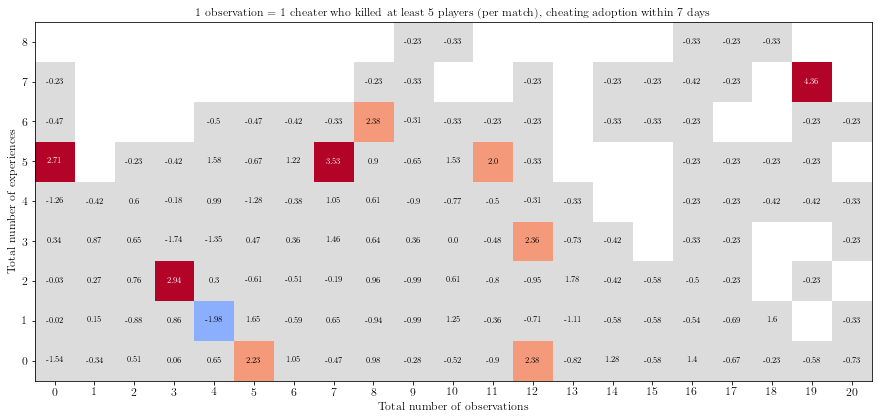

In [25]:
# Plot a heatmap.
cmap = plt.cm.get_cmap('coolwarm')
bounds = [piv.min().min(), -2.58, -1.96, 1.96, 2.58, piv.max().max()]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, cmap=cmap, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations')
plt.ylabel('Total number of experiences')

textcolors = ["k", "w"]

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] >= 2.58 or piv[x][y] < -2.58 else 0])

# colorbar(img1)
plt.show()
fig.savefig('emp_5_7.png')

In [6]:
freq_tab = pd.pivot_table(test_dat, values="emp_freq",index=["total_exp"], columns=["total_obs"])
print(freq_tab)

total_obs     0      1      2     3     4     5    6    7    8    9   ...  \
total_exp                                                             ...   
0          644.0  330.0  122.0  50.0  26.0  18.0  8.0  2.0  5.0  2.0  ...   
1          180.0  109.0   57.0  41.0  16.0  17.0  5.0  6.0  2.0  1.0  ...   
2           29.0   23.0   19.0  20.0  11.0   5.0  3.0  2.0  3.0  1.0  ...   
3           11.0    4.0    4.0   2.0   2.0   6.0  3.0  3.0  2.0  1.0  ...   
4            1.0    0.0    1.0   1.0   3.0   0.0  1.0  2.0  1.0  0.0  ...   
5            3.0    NaN    0.0   0.0   2.0   0.0  1.0  2.0  1.0  0.0  ...   
6            0.0    NaN    NaN   NaN   0.0   0.0  0.0  0.0  1.0  0.0  ...   
7            0.0    NaN    NaN   NaN   NaN   NaN  NaN  NaN  0.0  0.0  ...   
8            NaN    NaN    NaN   NaN   NaN   NaN  NaN  NaN  NaN  0.0  ...   

total_obs   11   12   13   14   15   16   17   18   19   20  
total_exp                                                    
0          0.0  1.0  1.0  2.

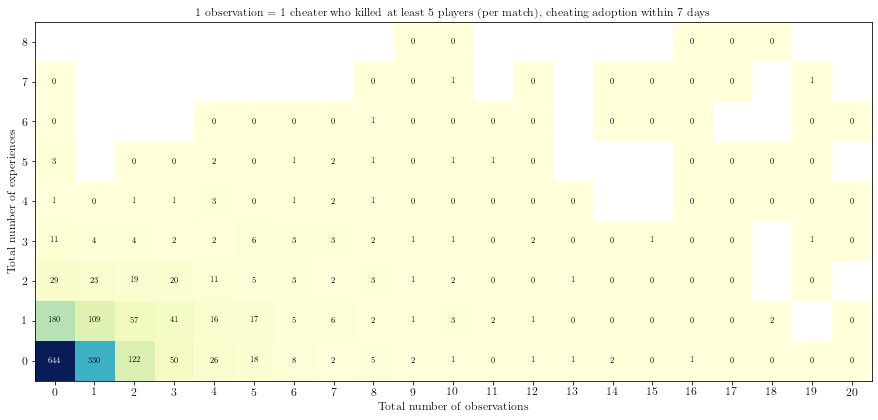

In [27]:
fig, ax = plt.subplots()
img1 = ax.imshow(freq_tab, cmap="YlGnBu")
ax.set_xticks(np.arange(freq_tab.shape[1]))
ax.set_yticks(np.arange(freq_tab.shape[0]))

textcolors = ["k", "w"]
threshold = 400

for y in range(freq_tab.shape[0]):
    for x in range(freq_tab.shape[1]):
        if np.isnan(freq_tab[x][y]) == False:
            text = ax.text(x, y, int(freq_tab[x][y]), ha="center", va="center",
                           color=textcolors[int(freq_tab[x][y]) > threshold])

plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations')
plt.ylabel('Total number of experiences')
plt.show()

fig.savefig('freq_5_7.png')

In [36]:
freq_tab = pd.pivot_table(test_dat, values="emp_freq",index=["total_exp"], columns=["total_obs"])
print(freq_tab)

total_obs     0      1     2     3     4     5    6    7    8    9   ...   11  \
total_exp                                                            ...        
0          228.0  208.0  92.0  50.0  30.0  19.0  9.0  6.0  4.0  1.0  ...  1.0   
1           99.0   40.0  34.0  19.0  10.0  10.0  7.0  5.0  2.0  0.0  ...  3.0   
2           14.0    3.0   4.0   4.0   6.0   5.0  5.0  1.0  0.0  1.0  ...  1.0   
3            7.0    0.0   0.0   2.0   0.0   0.0  3.0  1.0  0.0  NaN  ...  NaN   
4            0.0    NaN   NaN   NaN   0.0   1.0  0.0  0.0  NaN  NaN  ...  NaN   
5            1.0    NaN   NaN   NaN   NaN   NaN  0.0  NaN  0.0  NaN  ...  NaN   

total_obs   12   13   14   15   16   17   18   19   20  
total_exp                                               
0          0.0  0.0  1.0  1.0  0.0  NaN  0.0  0.0  NaN  
1          0.0  0.0  1.0  0.0  2.0  0.0  NaN  0.0  0.0  
2          0.0  0.0  0.0  NaN  0.0  0.0  0.0  NaN  NaN  
3          NaN  1.0  NaN  1.0  0.0  NaN  0.0  1.0  NaN  
4        

In [42]:
data = pd.read_csv("data/rev_data/emp_tab_1_7.csv")
data = data.rename(columns={'freq': 'emp_freq'})

rand_dat = pd.read_csv("data/rev_data/rand_tab_30_1_7_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','total_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
merged_df = merged_df.rename(columns={'freq': 'rand_freq_1'})

for i in range(2, 9):
    rand_dat = pd.read_csv("data/rev_data/rand_tab_30_1_7_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','total_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
    merged_df = merged_df.rename(columns={'freq': 'rand_freq_' + str(i)})

merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)

# Test a heatmap using the small dataset (with the results from three randomised networks and one empirical network).
test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['rand_std'] = test_dat.iloc[:, 3:].std(axis=1)

test_dat['observed_stat'] = (test_dat['emp_freq'] - test_dat['rand_mean']) / test_dat['rand_std']
test_dat = test_dat.round({"rand_mean":2, "rand_std":2, "observed_stat":2})
test_dat = test_dat.replace([np.inf, -np.inf], np.nan)
piv = pd.pivot_table(test_dat, values="observed_stat",index=["total_exp"], columns=["total_obs"])
print(piv)

total_obs    0     1     2     3     4     5     6     7     8     9   ...  \
total_exp                                                              ...   
0           NaN -0.37 -1.66  1.25 -1.52  0.44  0.93  0.52  1.02  1.71  ...   
1          0.23 -0.63  1.67 -1.25  2.05  1.64 -1.09 -0.40 -0.25 -1.60  ...   
2          0.24 -1.29 -1.73  0.76 -0.31 -0.71  0.63  1.51  0.00  3.65  ...   
3          0.55   NaN   NaN  0.38 -1.12 -0.71  3.00 -2.00  1.73 -0.77  ...   
4         -1.59   NaN   NaN   NaN   NaN   NaN   NaN   NaN -0.38   NaN  ...   
5          3.54   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6         -0.58   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
7         -0.38   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

total_obs    11    12    13    14    15    16    17    18    19    20  
total_exp                                                              
0         -0.41  0.46  0.18 -0.22  0.92 -0.75  0.50 -1.51 -0.83  4.24  
1  

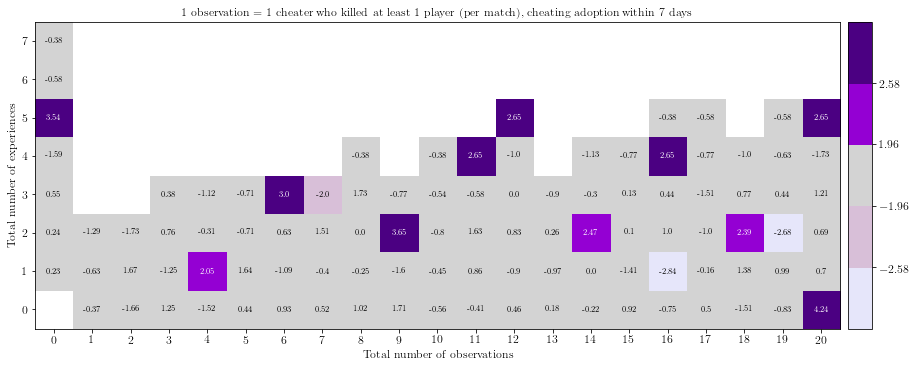

In [43]:
# Plot a heatmap.
cmap = matplotlib.colors.ListedColormap(['lavender', 'thistle', 'lightgray', 'darkviolet', 'indigo'])

bounds = [piv.min().min(), -2.58, -1.96, 1.96, 2.58, piv.max().max()]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, cmap=cmap, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 1 player (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations')
plt.ylabel('Total number of experiences')

textcolors = ["k", "w"]
threshold = 1.96

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[int(piv[x][y]) > threshold])

colorbar(img1)
plt.show()
fig.savefig('emp_1_7.png')

In [45]:
freq_tab = pd.pivot_table(test_dat, values="emp_freq",index=["total_exp"], columns=["total_obs"])
print(freq_tab)

total_obs    0      1      2      3      4     5     6     7     8     9   \
total_exp                                                                   
0           NaN  374.0  203.0  162.0  128.0  87.0  67.0  47.0  34.0  34.0   
1          89.0   31.0   45.0   27.0   40.0  31.0  23.0  18.0  17.0  12.0   
2          22.0    0.0    0.0    6.0    5.0   4.0   6.0   6.0   5.0   6.0   
3           9.0    NaN    NaN    1.0    0.0   0.0   2.0   0.0   1.0   0.0   
4           1.0    NaN    NaN    NaN    NaN   NaN   1.0   NaN   0.0   NaN   
5           3.0    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   
6           0.0    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   
7           0.0    NaN    NaN    NaN    NaN   NaN   NaN   NaN   NaN   NaN   

total_obs  ...    11    12    13    14    15   16   17   18   19   20  
total_exp  ...                                                         
0          ...  18.0  13.0  10.0  11.0  12.0  3.0  6.0  2.0  2.0  4.0  
1          ..

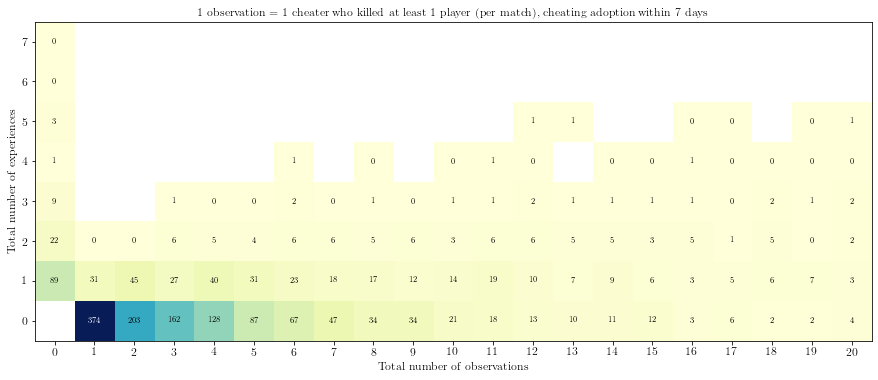

In [47]:
fig, ax = plt.subplots()
img1 = ax.imshow(freq_tab, cmap="YlGnBu")
ax.set_xticks(np.arange(freq_tab.shape[1]))
ax.set_yticks(np.arange(freq_tab.shape[0]))

textcolors = ["k", "w"]
threshold = 300

for y in range(freq_tab.shape[0]):
    for x in range(freq_tab.shape[1]):
        if np.isnan(freq_tab[x][y]) == False:
            text = ax.text(x, y, int(freq_tab[x][y]), ha="center", va="center",
                           color=textcolors[int(freq_tab[x][y]) > threshold])

plt.title('1 observation = 1 cheater who killed at least 1 player (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations')
plt.ylabel('Total number of experiences')
plt.show()

fig.savefig('freq_1_7.png')

In [48]:
data = pd.read_csv("data/rev_data/emp_tab_1_2.csv")
data = data.rename(columns={'freq': 'emp_freq'})

rand_dat = pd.read_csv("data/rev_data/rand_tab_30_1_2_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','total_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
merged_df = merged_df.rename(columns={'freq': 'rand_freq_1'})

for i in range(2, 9):
    rand_dat = pd.read_csv("data/rev_data/rand_tab_30_1_2_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','total_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
    merged_df = merged_df.rename(columns={'freq': 'rand_freq_' + str(i)})

merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)

# Test a heatmap using the small dataset (with the results from three randomised networks and one empirical network).
test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['rand_std'] = test_dat.iloc[:, 3:].std(axis=1)

test_dat['observed_stat'] = (test_dat['emp_freq'] - test_dat['rand_mean']) / test_dat['rand_std']
test_dat = test_dat.round({"rand_mean":2, "rand_std":2, "observed_stat":2})
test_dat = test_dat.replace([np.inf, -np.inf], np.nan)
piv = pd.pivot_table(test_dat, values="observed_stat",index=["total_exp"], columns=["total_obs"])
print(piv)

total_obs    0     1     2     3     4     5     6     7     8     9   ...  \
total_exp                                                              ...   
0           NaN  0.97 -2.12 -0.40 -2.97  0.50  0.65  0.92  1.33  2.77  ...   
1         -1.85 -1.70  1.61 -1.50  2.56  2.53 -1.46 -0.45 -0.98  0.67  ...   
2          0.59 -1.00 -1.15  0.69  0.28 -0.12  1.29  5.00  1.73  4.24  ...   
3          1.98   NaN   NaN  1.00 -0.77 -0.58   NaN -0.77  2.65   NaN  ...   
4         -1.89   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5          0.71   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

total_obs    11    12    13    14    15    16    17    18    19    20  
total_exp                                                              
0          0.29  0.18 -0.63  0.58 -0.34  0.45  1.51  0.30  0.00  0.71  
1          1.12 -0.35 -2.04 -0.89 -1.04  0.94  1.00 -0.69  0.21  1.29  
2         -0.58  0.00 -0.21  1.98  0.16 -0.83 -0.38 -0.58 -1.00 -0.54  
3         -0.77

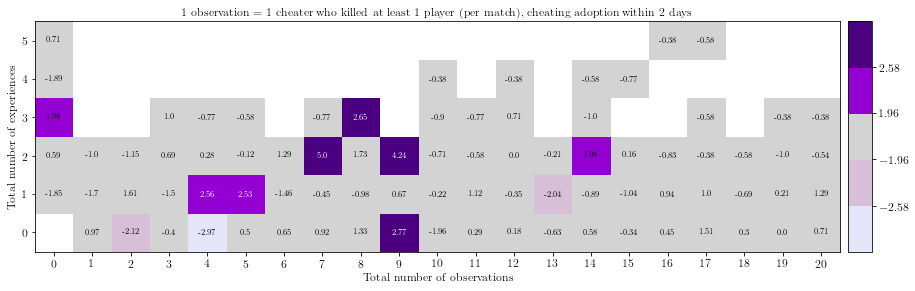

In [51]:
# Plot a heatmap.
cmap = matplotlib.colors.ListedColormap(['lavender', 'thistle', 'lightgray', 'darkviolet', 'indigo'])

bounds = [piv.min().min(), -2.58, -1.96, 1.96, 2.58, piv.max().max()]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, cmap=cmap, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 1 player (per match), cheating adoption within 2 days')
plt.xlabel('Total number of observations')
plt.ylabel('Total number of experiences')

textcolors = ["k", "w"]
threshold = 1.96

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[int(piv[x][y]) > threshold])

colorbar(img1)
plt.show()
fig.savefig('emp_1_2.png')

In [52]:
freq_tab = pd.pivot_table(test_dat, values="emp_freq",index=["total_exp"], columns=["total_obs"])
print(freq_tab)

total_obs    0      1      2     3     4     5     6     7     8     9   ...  \
total_exp                                                                ...   
0           NaN  235.0  108.0  88.0  63.0  43.0  25.0  22.0  14.0  14.0  ...   
1          83.0   18.0   25.0  15.0  24.0  15.0   6.0   6.0   4.0   7.0  ...   
2          13.0    0.0    0.0   4.0   3.0   2.0   3.0   4.0   2.0   4.0  ...   
3           6.0    NaN    NaN   1.0   0.0   0.0   1.0   0.0   1.0   NaN  ...   
4           0.0    NaN    NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN  ...   
5           1.0    NaN    NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

total_obs   11   12   13   14   15   16   17   18   19   20  
total_exp                                                    
0          9.0  5.0  3.0  6.0  4.0  2.0  2.0  1.0  1.0  1.0  
1          7.0  4.0  0.0  1.0  1.0  2.0  3.0  0.0  1.0  1.0  
2          1.0  2.0  1.0  2.0  1.0  0.0  0.0  0.0  0.0  0.0  
3          0.0  1.0  1.0  0.0  1.0  1.0  0.0  NaN

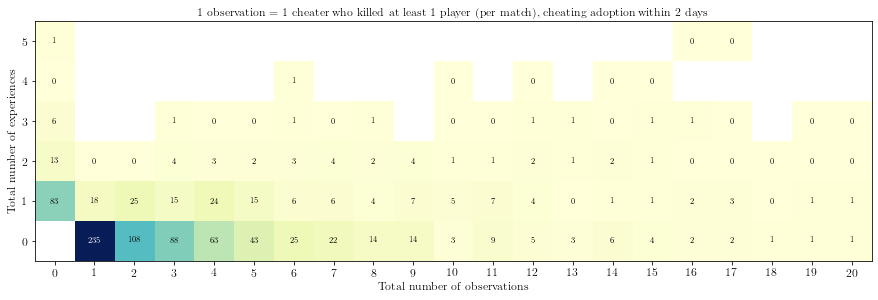

In [53]:
fig, ax = plt.subplots()
img1 = ax.imshow(freq_tab, cmap="YlGnBu")
ax.set_xticks(np.arange(freq_tab.shape[1]))
ax.set_yticks(np.arange(freq_tab.shape[0]))

textcolors = ["k", "w"]
threshold = 200

for y in range(freq_tab.shape[0]):
    for x in range(freq_tab.shape[1]):
        if np.isnan(freq_tab[x][y]) == False:
            text = ax.text(x, y, int(freq_tab[x][y]), ha="center", va="center",
                           color=textcolors[int(freq_tab[x][y]) > threshold])

plt.title('1 observation = 1 cheater who killed at least 1 player (per match), cheating adoption within 2 days')
plt.xlabel('Total number of observations')
plt.ylabel('Total number of experiences')
plt.show()

fig.savefig('freq_1_2.png')

### Create a heatmap using the new test statistics.

In [8]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors
import scipy.stats

In [9]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 12, # Adjust the font size of x and y labels.
    'axes.titlesize': 12,
    'font.size': 8, 
    'legend.fontsize': 6,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'text.usetex': True,
    'figure.figsize': [15, 7],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)


def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax, 
                        ticks=[-np.inf, 0.01, 0.05, np.inf])
    plt.sca(last_axes)
    return cbar

In [10]:
data = pd.read_csv("data/corrected_data/emp_tab_5_7.csv")
data = data.rename(columns={'freq': 'emp_freq'})

rand_dat = pd.read_csv("data/corrected_data/rand_tab_30_5_7_1.csv")
merged_df = pd.merge(data, rand_dat, on=['total_obs','total_exp'], how='outer')
merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
merged_df = merged_df.rename(columns={'freq': 'rand_freq_1'})

for i in range(2, 21):
    rand_dat = pd.read_csv("data/corrected_data/rand_tab_30_5_7_" + str(i) + ".csv")
    merged_df = pd.merge(merged_df, rand_dat, on=['total_obs','total_exp'], how='outer')
    merged_df = merged_df.fillna(0).sort_values(by=['total_obs','total_exp'])
    merged_df = merged_df.rename(columns={'freq': 'rand_freq_' + str(i)})

merged_df = merged_df.drop(merged_df[merged_df.total_obs > 20].index)
merged_df = merged_df.drop(merged_df[merged_df.total_exp > 8].index)

In [11]:
print(merged_df.head())

   total_obs  total_exp  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3  \
0          0          0     644.0        654.0        653.0        662.0   
1          0          1     180.0        184.0        196.0        180.0   
2          0          2      29.0         29.0         21.0         33.0   
3          0          3      11.0          7.0         14.0         10.0   
4          0          4       1.0          6.0          2.0          1.0   

   rand_freq_4  rand_freq_5  rand_freq_6  rand_freq_7  ...  rand_freq_11  \
0        685.0        651.0        656.0        655.0  ...         663.0   
1        173.0        175.0        186.0        175.0  ...         184.0   
2         28.0         28.0         27.0         31.0  ...          27.0   
3          8.0          7.0          7.0          7.0  ...          11.0   
4          3.0          3.0          4.0          3.0  ...           3.0   

   rand_freq_12  rand_freq_13  rand_freq_14  rand_freq_15  rand_freq_16  \
0         6

In [12]:
# Test a heatmap using the small dataset (with the results from three randomised networks and one empirical network).
test_dat = merged_df.sort_values(['total_exp', 'total_obs']).reset_index(drop=True)

test_dat['rand_mean'] = test_dat.iloc[:, 3:].mean(axis=1)
test_dat['cdf'] = scipy.stats.poisson.cdf(test_dat['emp_freq'], test_dat['rand_mean'])
test_dat['pmf'] = scipy.stats.poisson.pmf(test_dat['emp_freq'], test_dat['rand_mean'])
test_dat['prob'] = 1 - test_dat['cdf'] + test_dat['pmf']

test_dat = test_dat.round({"rand_mean":2, "cdf":3, "pmf":3, "prob":3})

In [13]:
print(test_dat.head())

   total_obs  total_exp  emp_freq  rand_freq_1  rand_freq_2  rand_freq_3  \
0          0          0     644.0        654.0        653.0        662.0   
1          1          0     330.0        320.0        331.0        329.0   
2          2          0     122.0        111.0        117.0        120.0   
3          3          0      50.0         58.0         43.0         50.0   
4          4          0      26.0         30.0         18.0         26.0   

   rand_freq_4  rand_freq_5  rand_freq_6  rand_freq_7  ...  rand_freq_15  \
0        685.0        651.0        656.0        655.0  ...         644.0   
1        325.0        335.0        334.0        340.0  ...         355.0   
2        113.0        122.0        120.0        121.0  ...         126.0   
3         51.0         52.0         60.0         43.0  ...          53.0   
4         20.0         23.0         22.0         31.0  ...          24.0   

   rand_freq_16  rand_freq_17  rand_freq_18  rand_freq_19  rand_freq_20  \
0         6

In [14]:
piv = pd.pivot_table(test_dat, values="prob",index=["total_exp"], columns=["total_obs"])
print(piv)

total_obs     0      1      2      3      4      5      6      7      8   \
total_exp                                                                  
0          0.745  0.581  0.409  0.502  0.318  0.065  0.277  0.751  0.294   
1          0.514  0.455  0.754  0.288  0.902  0.172  0.735  0.289  0.853   
2          0.532  0.418  0.274  0.039  0.454  0.782  0.739  0.669  0.283   
3          0.417  0.253  0.353  0.941  0.931  0.384  0.456  0.191  0.391   
4          0.961  1.000  0.451  0.683  0.243  1.000  0.741  0.228  0.478   
5          0.041    NaN  1.000  1.000  0.209  1.000  0.330  0.018  0.330   
6          1.000    NaN    NaN    NaN  1.000  1.000  1.000  1.000  0.139   
7          1.000    NaN    NaN    NaN    NaN    NaN    NaN    NaN  1.000   
8            NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

total_obs     9   ...     11     12     13     14   15     16   17     18  \
total_exp         ...                                                       
0        

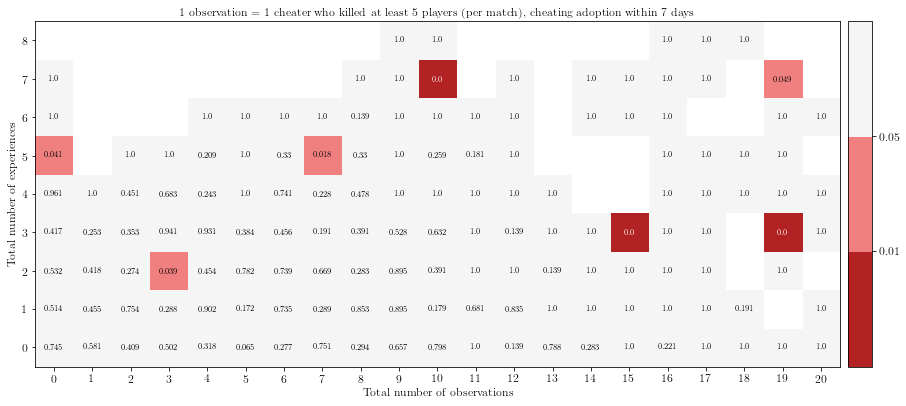

In [16]:
# Plot a heatmap.
cmap = matplotlib.colors.ListedColormap(['firebrick','lightcoral', 'whitesmoke'])

bounds = [piv.min().min(), 0.01, 0.05, piv.max().max()]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots()
img1 = ax.imshow(piv, cmap=cmap, norm=norm)
ax.set_xticks(np.arange(piv.shape[1]))
ax.set_yticks(np.arange(piv.shape[0]))
plt.title('1 observation = 1 cheater who killed at least 5 players (per match), cheating adoption within 7 days')
plt.xlabel('Total number of observations')
plt.ylabel('Total number of experiences')

textcolors = ["k", "w"]
threshold = 0.01

for y in range(piv.shape[0]):
    for x in range(piv.shape[1]):
        if np.isnan(piv[x][y]) == False:
            text = ax.text(x, y, piv[x][y], ha="center", va="center",
                           color=textcolors[1 if piv[x][y] <= threshold else 0])

colorbar(img1)
plt.show()
fig.savefig('p_vals.png')